# 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.misc
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import imageio
from skimage.transform import resize

%matplotlib inline

# 2. Overview of the Problem set

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

测试

y = [1], it's a cat'picture.'


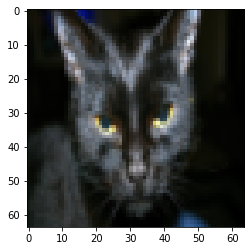

In [3]:
index = 25
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[:,index]) + ", it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "'picture.'")


将图像大小为(num_px, num_px, 3)的矩阵转化为大小为(num_px * num_px * 3, 1)的列向量

In [4]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [5]:
# reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


标准化数据集, 使数据集的数据落在(0, 1)的区间

In [6]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

预处理数据集的一般步骤:
   - 找出尺寸和形状(m_train,m_test,num_px,...)
   - 将数据集的矩阵重新做成一个大小为(num_px * num_px * 3, 1)的向量
   - 标准化数据

# 3. General Architecture of the learning algorithm

<img style="float: center;" src="https://note.youdao.com/yws/public/resource/9453319240261956a5cf7524507c4cfc/xmlnote/ACAE027365EA4A51B8C90E2080E41C93/1815" width="50%"> 

**算法的数学表达:**
$$
z^{(i)} = w^Tx^{(i)} + b \\
\hat y^{(i)} = a^{(i)} = sigmoid(z^{(i)})\\
\ell (a^{(i)},y^{(i)}) = - y^{(i)}\log (a^{(i)})-(1-y^{(i)})\log (1-a^{(i)})
$$

损失函数:
$$
J = \frac{1}{m}\sum^{m}_{i=1}\ell (a^{(i)},y^{(i)})
$$


# 4. Building the parts of our algorithm
建立神经网络的主要步骤:
1. 定义模型结构
2. 初始化模型参数
3. 循环
    - 计算当前的损失(误差)
    - 计算当前梯度
    - 更新参数

## 4.1 辅助函数

构造sigmoid函数

In [7]:
# graded function: sigmoid

def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    
    return s

测试:

In [8]:
print("sigmoid(0) = " + str(sigmoid(0)))
print("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


## 4.2 初始化参数

np.zeros()的使用方法:
   
    zeros(shape, dtype=float, order='C')
    shape: 数据尺寸

In [9]:
# graded function: initialize_with_zeros

def initialize_with_zeros(dim):
    w = np.zeros(shape = (dim, 1)) # 初始化向量的size
    b = 0  # 初始化偏置
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, int) or isinstance(b, float))
    
    return w,b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


## 4.3 向前向后传播

$$
\sigma(z) = \sigma(w^TX + b)=\frac{1}{1+e^{-x}}\\
\ell(\hat y,y) = -(y\log\hat y + (1-y)\log{(1-\hat y)})
dw= xdz\\
db = dz\\
dz = a -y
$$

In [11]:
def propagate(w,b,X,Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1 / m)* np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    
    dw = (1 / m) * np.dot(X, (A-Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {"dw":dw,
             "db":db}
    return grads, cost
    

In [12]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w,b,X,Y)
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("cost =" + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost =6.000064773192205


**优化参数:**
$$
w := w - \alpha dw\\
b:= b- \alpha db
$$

In [13]:
# graded function: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print("cost after iteration %i: %f" %(i, cost))
            
    params = {"w":w,
              "b":b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs
            

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**预测:**

求出$\sigma(w^TX+ b)$
得出一个在(0,1)之间的数值

若值小于等于0.5则置零, 否则置一, 即凭借这个值来进行判断

In [15]:
# graded function: predict

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T, X)+ b)
    
    for i in range(A.shape[1]):
        Y_prediction[0,i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [16]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


## model

创建一个model来将上面零散的函数装起来

In [17]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    
    #Gradient decent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["w"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [18]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

cost after iteration 0: 0.693147
cost after iteration 100: 0.584508
cost after iteration 200: 0.466949
cost after iteration 300: 0.376007
cost after iteration 400: 0.331463
cost after iteration 500: 0.303273
cost after iteration 600: 0.279880
cost after iteration 700: 0.260042
cost after iteration 800: 0.242941
cost after iteration 900: 0.228004
cost after iteration 1000: 0.214820
cost after iteration 1100: 0.203078
cost after iteration 1200: 0.192544
cost after iteration 1300: 0.183033
cost after iteration 1400: 0.174399
cost after iteration 1500: 0.166521
cost after iteration 1600: 0.159305
cost after iteration 1700: 0.152667
cost after iteration 1800: 0.146542
cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


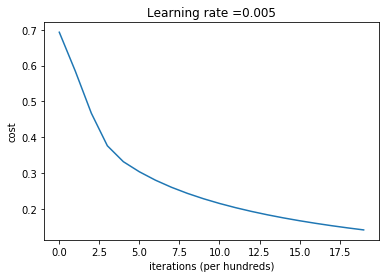

In [19]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 89.47368421052632 %
test accuracy: 66.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



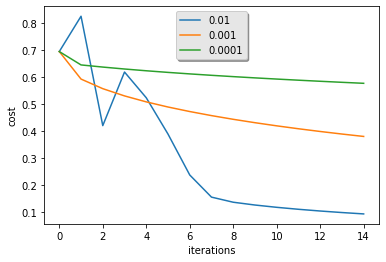

In [20]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

y = 0.0, your algorithm predicts a "non-cat" picture.


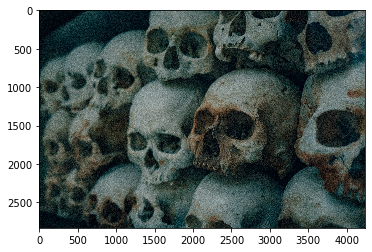

In [21]:
my_image = r"test.jpg"  

fname = "images/" + my_image
image = np.array(imageio.imread(fname))
my_image = resize(image, output_shape=(num_px, num_px)).reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")